In [ ]:
!pip -q install transformers datasets evaluate accelerate sentencepiece rouge-score matplotlib pandas numpy torch

In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

rouge = evaluate.load("rouge")

Using device: cuda


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def generate_summary(model, tokenizer, text, device, max_input_len=512, max_new_tokens=80):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_len
    ).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True
        )

    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

In [ ]:
dataset_name = "xsum"
sample_n = 30   # Change to 50 if GPU

data = load_dataset(dataset_name, split="test").select(range(sample_n))
print("Loaded dataset:", dataset_name)
print("Number of samples:", len(data))

Loaded dataset: xsum
Number of samples: 30


In [ ]:
models_to_test = [
    "facebook/bart-large-cnn",
    "sshleifer/distilbart-cnn-12-6",
    "t5-base",
    "google/pegasus-xsum"
]

models_to_test

['facebook/bart-large-cnn',
 'sshleifer/distilbart-cnn-12-6',
 't5-base',
 'google/pegasus-xsum']

In [ ]:
results = []

for model_name in models_to_test:
    print("\n==============================")
    print("Testing model:", model_name)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    model.eval()

    params = count_parameters(model) / 1e6

    preds = []
    refs = []
    times = []

    for i in range(len(data)):
        text = data[i]["document"]
        reference = data[i]["summary"]

        if device == "cuda":
            torch.cuda.synchronize()
        start = time.time()

        pred = generate_summary(model, tokenizer, text, device)

        if device == "cuda":
            torch.cuda.synchronize()
        end = time.time()

        preds.append(pred)
        refs.append(reference)
        times.append(end - start)

        if (i + 1) % 10 == 0:
            print("Processed", i + 1, "/", len(data))

    rouge_scores = rouge.compute(predictions=preds, references=refs)

    results.append({
        "Model": model_name,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "AvgTimeSec": np.mean(times),
        "Params(M)": params
    })

    del model, tokenizer
    if device == "cuda":
        torch.cuda.empty_cache()

df = pd.DataFrame(results)
df


Testing model: facebook/bart-large-cnn


Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

Processed 10 / 30
Processed 20 / 30
Processed 30 / 30

Testing model: sshleifer/distilbart-cnn-12-6


Loading weights:   0%|          | 0/358 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Processed 10 / 30
Processed 20 / 30
Processed 30 / 30

Testing model: t5-base


Loading weights:   0%|          | 0/257 [00:00<?, ?it/s]

Processed 10 / 30
Processed 20 / 30
Processed 30 / 30

Testing model: google/pegasus-xsum


Loading weights:   0%|          | 0/680 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
PegasusForConditionalGeneration LOAD REPORT from: google/pegasus-xsum
Key                                  | Status  | 
-------------------------------------+---------+-
model.encoder.embed_positions.weight | MISSING | 
model.decoder.embed_positions.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Processed 10 / 30
Processed 20 / 30
Processed 30 / 30


,Model,ROUGE-1,ROUGE-2,ROUGE-L,AvgTimeSec,Params(M)
0,facebook/bart-large-cnn,0.200920,0.042212,0.122468,1.064384,406.290432
1,sshleifer/distilbart-cnn-12-6,0.202336,0.042519,0.129128,0.710063,408.451072
2,t5-base,0.203528,0.038908,0.143813,1.778730,222.903552
3,google/pegasus-xsum,0.503287,0.298297,0.434210,0.533498,766.567424


In [ ]:
df.to_csv("topsis_summarization_results.csv", index=False)
print("CSV Saved Successfully")

CSV Saved Successfully


In [ ]:
def topsis(decision_matrix, weights, impacts):
    X = np.array(decision_matrix, dtype=float)

    R = X / np.sqrt((X ** 2).sum(axis=0))
    W = np.array(weights) / sum(weights)
    V = R * W

    ideal_best = []
    ideal_worst = []

    for j in range(V.shape[1]):
        if impacts[j] == "+":
            ideal_best.append(V[:, j].max())
            ideal_worst.append(V[:, j].min())
        else:
            ideal_best.append(V[:, j].min())
            ideal_worst.append(V[:, j].max())

    ideal_best = np.array(ideal_best)
    ideal_worst = np.array(ideal_worst)

    dist_best = np.sqrt(((V - ideal_best) ** 2).sum(axis=1))
    dist_worst = np.sqrt(((V - ideal_worst) ** 2).sum(axis=1))

    scores = dist_worst / (dist_best + dist_worst)
    ranks = (-scores).argsort().argsort() + 1

    return scores, ranks

criteria_cols = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "AvgTimeSec", "Params(M)"]

weights = [3, 4, 3, 2, 1]
impacts = ["+", "+", "+", "-", "-"]

scores, ranks = topsis(df[criteria_cols].values.tolist(), weights, impacts)

df["TOPSIS_Score"] = scores
df["Rank"] = ranks

df = df.sort_values("Rank").reset_index(drop=True)
df

,Model,ROUGE-1,ROUGE-2,ROUGE-L,AvgTimeSec,Params(M),TOPSIS_Score,Rank
0,google/pegasus-xsum,0.503287,0.298297,0.434210,0.533498,766.567424,0.886165,1
1,sshleifer/distilbart-cnn-12-6,0.202336,0.042519,0.129128,0.710063,408.451072,0.198667,2
2,facebook/bart-large-cnn,0.200920,0.042212,0.122468,1.064384,406.290432,0.150075,3
3,t5-base,0.203528,0.038908,0.143813,1.778730,222.903552,0.118101,4


In [ ]:
df.to_csv("topsis_summarization_results.csv", index=False)
print("Updated CSV Saved")

Updated CSV Saved


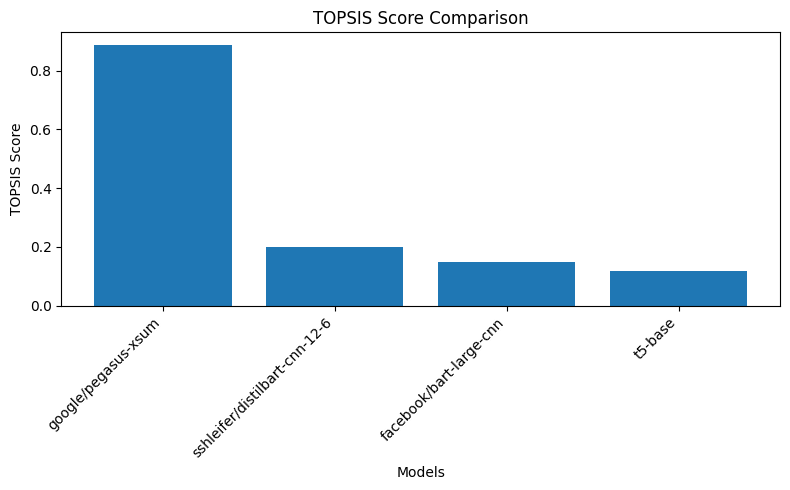

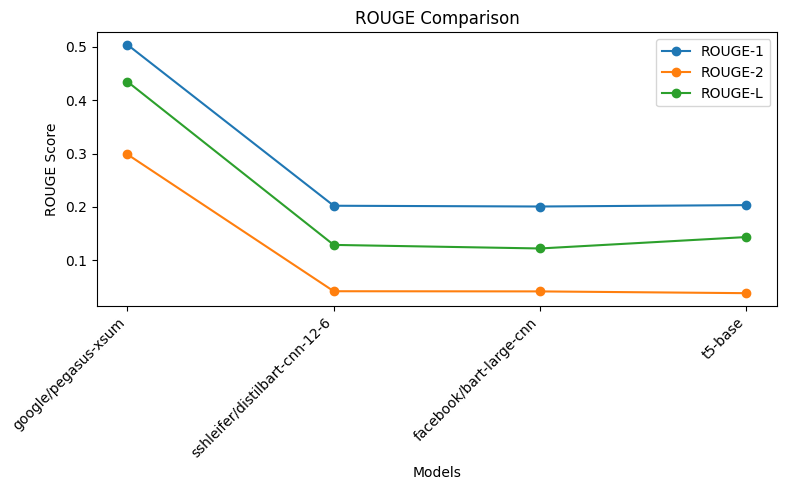

Graphs Saved


In [ ]:
# TOPSIS Score Bar Graph
plt.figure(figsize=(8,5))
plt.bar(df["Model"], df["TOPSIS_Score"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Models")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Score Comparison")
plt.tight_layout()
plt.savefig("topsis_scores_bar.png", dpi=300)
plt.show()

# ROUGE Line Graph
plt.figure(figsize=(8,5))
plt.plot(df["Model"], df["ROUGE-1"], marker="o", label="ROUGE-1")
plt.plot(df["Model"], df["ROUGE-2"], marker="o", label="ROUGE-2")
plt.plot(df["Model"], df["ROUGE-L"], marker="o", label="ROUGE-L")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Models")
plt.ylabel("ROUGE Score")
plt.title("ROUGE Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("rouge_metrics_line.png", dpi=300)
plt.show()

print("Graphs Saved")

In [ ]:
from google.colab import files

files.download("topsis_summarization_results.csv")
files.download("topsis_scores_bar.png")
files.download("rouge_metrics_line.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>